In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchview import draw_graph
import graphviz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

RANDOM_SEED = 1
BATCH_SIZE = 32
LEARN_RATE = 0.001
MAX_NUM_EPOCH = 100
VISUALIZE_MODEL = False

Current device: cuda


In [2]:
from models.CAE import CNN1D
model = CNN1D()
model.to(device)

if VISUALIZE_MODEL:
    model_graph = draw_graph(
        model,
        input_size=[(BATCH_SIZE, 84), (BATCH_SIZE, 4)],
        expand_nested=True)
    display(model_graph.visual_graph)

Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340


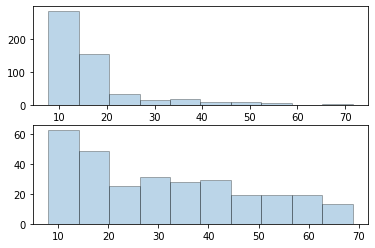

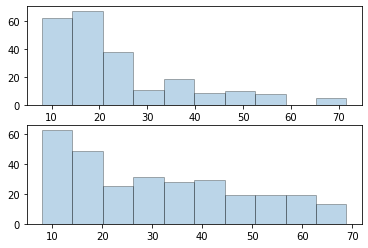

# of valid CSA samples w/o NaN: 524
# of subjects w/ valid CSA samples: 209
# of healthy samples: 295
# of asthma sampels: 229


In [7]:
from data.aware import AwareDataset, LeaveOneOutSplitter

dataset = AwareDataset(csv_data = 'data/exhale_data_v8_ave.csv',
                       csv_outcome = 'data/exhale_outcome_v8_ave.csv',
                       csv_info = 'data/exhale_verbose_v8_ave.csv',
                       root_dir = 'data/',
                       target_classes = [0,1])

splitter = LeaveOneOutSplitter(dataset, BATCH_SIZE, random_seed=RANDOM_SEED)

In [4]:
import time
import jupyter_beeper

from trainer.pretrain import PreTrainer
from trainer.finetune import FineTuner
from utils.others import weight_reset, Outputs
from utils.clustering import evaluate
from utils.outlier import novelty_detection

metrics_cluster = np.zeros((5,3,3))
outputs_test = Outputs()

beeper = jupyter_beeper.Beeper()

timestr = time.strftime("%Y%m%d-%H%M%S")
for split_idx, (train_loader, test_loader) in enumerate(splitter):
    print("\nFold #" + str(split_idx))
    writer = SummaryWriter("runs/" + timestr + "-fold" + str(split_idx))
    model.apply(weight_reset)

    print("Pre-training...")
    model.pre_train()
    pre_trainer = PreTrainer(
        model,
        lr = LEARN_RATE,
        T_max = MAX_NUM_EPOCH,
        device = device,
        summarywriter = writer
    )
    for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
        pre_trainer.train(epoch, train_loader)
    pre_trainer.save(pre_trainer.train_loss, epoch)
    
    print("Fine-tuning...")
    model.fine_tune()
    fine_tuner = FineTuner(
        model,
        lr = LEARN_RATE,
        T_max = MAX_NUM_EPOCH,
        device = device,
        summarywriter = writer
    )
    for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
        fine_tuner.train(epoch, train_loader)
    fine_tuner.save(fine_tuner.train_acc, epoch)
    print("Test:")
    fine_tuner.test(test_loader)
    outputs_test.append_from(fine_tuner)
    
#     if split_idx == 2:
#         beeper.beep(frequency=600, secs=0.5)
#         break
    



Fold #0
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #1
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #2
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #3
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 20.00%
On which epoch reach the highest accuracy: 99

Fold #4
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 80.00%
On which epoch reach the highest accuracy: 99

Fold #5
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #6
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #7
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #8
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #9
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #10
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #11
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #12
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #13
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #14
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #15
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #16
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #17
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #18
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #19
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #20
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #21
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 40.00%
On which epoch reach the highest accuracy: 99

Fold #22
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #23
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #24
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #25
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #26
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #27
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #28
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #29
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #30
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #31
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #32
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #33
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #34
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #35
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 75.00%
On which epoch reach the highest accuracy: 99

Fold #36
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #37
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #38
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #39
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #40
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #41
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #42
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #43
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #44
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 75.00%
On which epoch reach the highest accuracy: 99

Fold #45
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #46
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #47
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #48
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #49
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #50
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #51
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #52
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 75.00%
On which epoch reach the highest accuracy: 99

Fold #53
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #54
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #55
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #56
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #57
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #58
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #59
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #60
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #61
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #62
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #63
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #64
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 75.00%
On which epoch reach the highest accuracy: 99

Fold #65
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #66
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #67
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #68
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #69
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #70
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #71
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #72
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #73
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #74
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #75
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #76
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #77
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #78
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #79
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #80
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #81
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #82
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #83
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #84
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #85
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #86
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #87
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #88
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #89
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 40.00%
On which epoch reach the highest accuracy: 99

Fold #90
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #91
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #92
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #93
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #94
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #95
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #96
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #97
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #98
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #99
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #100
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #101
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #102
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #103
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #104
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #105
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #106
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #107
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #108
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #109
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 80.00%
On which epoch reach the highest accuracy: 99

Fold #110
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #111
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #112
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #113
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #114
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #115
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #116
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #117
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #118
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #119
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #120
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #121
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #122
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 80.00%
On which epoch reach the highest accuracy: 99

Fold #123
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #124
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #125
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #126
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #127
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #128
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #129
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #130
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #131
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #132
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #133
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #134
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #135
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #136
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #137
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #138
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #139
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 40.00%
On which epoch reach the highest accuracy: 99

Fold #140
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 75.00%
On which epoch reach the highest accuracy: 99

Fold #141
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #142
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #143
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #144
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #145
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #146
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #147
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #148
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #149
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #150
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #151
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #152
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #153
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #154
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #155
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #156
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #157
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #158
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #159
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #160
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #161
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #162
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #163
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #164
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #165
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #166
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #167
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #168
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #169
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #170
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #171
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #172
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #173
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #174
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #175
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #176
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #177
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #178
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #179
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #180
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #181
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 25.00%
On which epoch reach the highest accuracy: 99

Fold #182
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #183
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #184
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #185
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #186
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #187
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #188
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #189
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #190
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #191
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #192
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #193
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #194
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #195
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #196
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #197
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #198
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #199
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #200
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #201
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #202
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #203
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #204
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #205
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #206
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #207
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #208
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #209
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #210
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #211
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #212
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #213
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #214
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #215
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #216
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #217
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #218
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #219
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #220
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #221
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #222
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #223
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #224
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #225
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #226
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #227
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #228
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #229
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #230
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #231
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #232
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #233
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #234
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #235
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #236
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #237
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #238
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #239
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #240
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #241
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #242
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #243
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 50.00%
On which epoch reach the highest accuracy: 99

Fold #244
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #245
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #246
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #247
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #248
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #249
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #250
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #251
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #252
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #253
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #254
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #255
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #256
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #257
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 33.33%
On which epoch reach the highest accuracy: 99

Fold #258
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #259
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #260
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 66.67%
On which epoch reach the highest accuracy: 99

Fold #261
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #262
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #263
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99

Fold #264
Pre-training...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #265
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 0.00%
On which epoch reach the highest accuracy: 99

Fold #266
Pre-training...


/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Fine-tuning...


  0%|          | 0.00/100 [00:00<?, ?epoch/s]

Test:
Best fine-tuning accuracy (balanced): 100.00%
On which epoch reach the highest accuracy: 99


In [5]:
import pandas as pd
print(outputs_test)
# print(outputs_test.outputs)
outputs_test.outputs.to_csv('data/'+timestr+'.csv', index=False)

# beeper.beep(frequency=600, secs=0.5)

                                                Labels  \
0    [1.0, 4.5, 80.19999694824219, 0.76999998092651...   
1    [1.0, 2.5299999713897705, 89.4000015258789, 3....   
2    [1.0, 3.880000114440918, 81.30000305175781, 3....   
3    [1.0, 3.880000114440918, 81.30000305175781, 3....   
4    [1.0, 3.880000114440918, 81.30000305175781, 3....   
..                                                 ...   
832  [0.0, 2.5299999713897705, 87.19999694824219, 2...   
833  [0.0, 2.5299999713897705, 87.19999694824219, 2...   
834  [0.0, 2.5299999713897705, 87.19999694824219, 2...   
835  [1.0, 2.9200000762939453, 52.70000076293945, 1...   
836  [1.0, 2.9200000762939453, 52.70000076293945, 1...   

                                                  Info  \
0    [3.0, 1.0, 15.100000381469727, 1.0, 169.0, 87....   
1    [4.0, 1.0, 14.699999809265137, 1.0, 157.0, 47....   
2    [6.0, 1.0, 12.600000381469727, 0.0, 163.699996...   
3    [6.0, 2.0, 12.600000381469727, 0.0, 163.699996...   
4    [6.0, 3.

     Diagnosis  Prediction  FEV1   FEV1/FVC  FEF2575  FEV1_pred  \
0          1.0    0.785025  4.50  80.199997     0.77      121.0   
1          1.0    0.897337  2.53  89.400002     3.08       82.0   
2          1.0    0.999999  3.88  81.300003     3.82      150.0   
3          1.0    0.999997  3.88  81.300003     3.82      150.0   
4          1.0    1.000000  3.88  81.300003     3.82      150.0   
..         ...         ...   ...        ...      ...        ...   
832        0.0    0.990702  2.53  87.199997     2.37       97.0   
833        0.0    0.997560  2.53  87.199997     2.37       97.0   
834        0.0    0.997931  2.53  87.199997     2.37       97.0   
835        1.0    0.999971  2.92  52.700001     1.65       64.0   
836        1.0    0.988204  2.92  52.700001     1.65       64.0   

     FEV1/FVC_pred  FEF2575_pred    R5  R5_20  ...     ID  Trial        Age  \
0             92.0          96.0   NaN    NaN  ...    3.0    1.0  15.100000   
1            102.0          86.0   Na

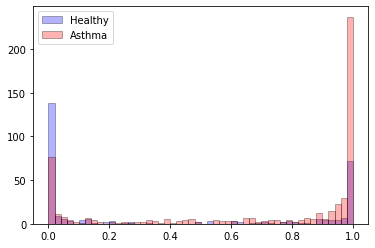

Sens: 0.7158671586715867
Spec: 0.6
BalAcc: 0.6579335793357933


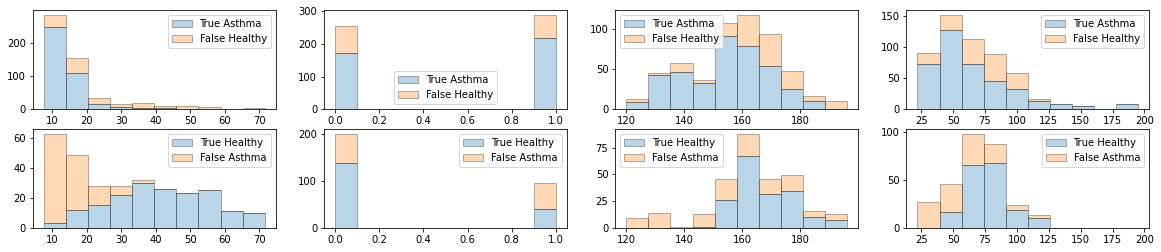

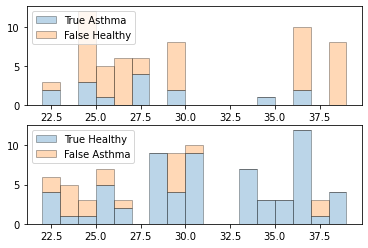

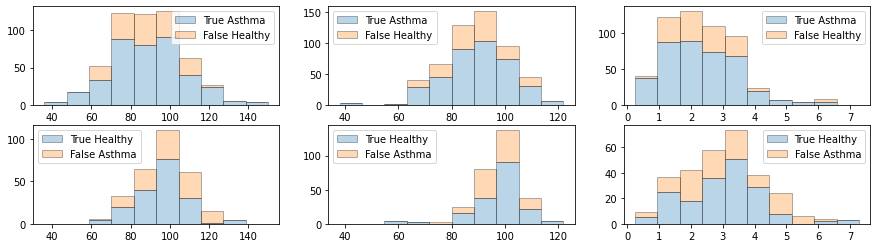

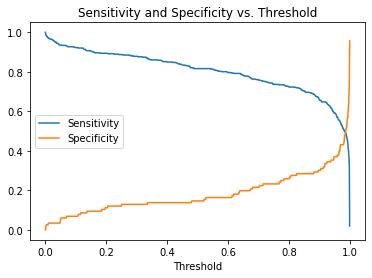

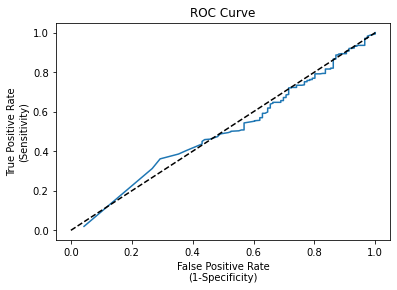

In [270]:
import ast
import matplotlib.pyplot as plt
import scikitplot as skplt

def convert(val):
    return ast.literal_eval(val.replace('nan', 'None'))

outputs_test.outputs = pd.read_csv(
    'data/20231115-122738.csv', 
    converters={
        0: convert,
        1: convert,
        2: convert,
        3: convert
    }
)

labels = outputs_test.outputs['Labels'].to_list()
labels = pd.DataFrame(labels)
labels.columns = ['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score']

info = outputs_test.outputs['Info'].to_list()
info = pd.DataFrame(info)
info.columns = ['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina']

meta = pd.concat([labels, info], axis=1)

outputs_cls = outputs_test.outputs['Outputs_cls'].to_list()
outputs_cls = pd.DataFrame(outputs_cls)

meta.insert(1, 'Prediction', outputs_cls[1])

print(meta)

idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=0.5)
tp = idx_tp.sum()
idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=0.5)
fp = idx_fp.sum()
idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<0.5)
tn = idx_tn.sum()
idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<0.5)
fn = idx_fn.sum()
print(tn, fp)
print(fn, tp)

plt.figure()
plt.hist(meta['Prediction'][meta['Diagnosis']==0], bins=50, alpha = 0.3, color='b', edgecolor='k', linewidth=1)
plt.hist(meta['Prediction'][meta['Diagnosis']==1], bins=50, alpha = 0.3, color='r', edgecolor='k', linewidth=1)
plt.legend(['Healthy', 'Asthma'])
plt.show()

# cross_entropy = -(y_true*np.log10(y_pred[1]) + (1-y_true)*np.log10(y_pred[0]))

# plt.figure()
# # plt.hist(cross_entropy, bins=np.logspace(np.log10(0.1),np.log10(10.0), 50), edgecolor='k', linewidth=1)
# plt.hist(cross_entropy, bins=50, edgecolor='k', linewidth=1)
# plt.legend(['Healthy', 'Asthma'])
# # plt.gca().set_xscale("log")
# plt.vlines(-np.log10(0.5), 0, 500, color='r')
# plt.show()

# y_pred = y_pred.idxmax(axis=1)

sens = tp/(tp+fn)
spec = tn/(fp+tn)
print('Sens:', sens)
print('Spec:', spec)
print('BalAcc:', (sens+spec)/2)

plt.figure(figsize=(20,4))
plt.subplot(2,4,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,5)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,2)
plt.hist(pd.concat([meta['Sex'][idx_tp], meta['Sex'][idx_fn]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,6)
plt.hist(pd.concat([meta['Sex'][idx_tn], meta['Sex'][idx_fp]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,3)
plt.hist(pd.concat([meta['Height'][idx_tp], meta['Height'][idx_fn]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,7)
plt.hist(pd.concat([meta['Height'][idx_tn], meta['Height'][idx_fp]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,4)
plt.hist(pd.concat([meta['Weight'][idx_tp], meta['Weight'][idx_fn]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,8)
plt.hist(pd.concat([meta['Weight'][idx_tn], meta['Weight'][idx_fp]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), bins=list(range(22,40,1)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,1,2)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), bins=list(range(22,40,1)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(2,3,1)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tp], meta['FEV1_pred'][idx_fn]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,4)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tn], meta['FEV1_pred'][idx_fp]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,2)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tp], meta['FEV1/FVC_pred'][idx_fn]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,5)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tn], meta['FEV1/FVC_pred'][idx_fp]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,3)
plt.hist(pd.concat([meta['FEF2575'][idx_tp], meta['FEF2575'][idx_fn]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,6)
plt.hist(pd.concat([meta['FEF2575'][idx_tn], meta['FEF2575'][idx_fp]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

thre = np.zeros(1001)
sens = np.zeros(1001)
spec = np.zeros(1001)
for i in range(0,1001):
    idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=i/1000) & (meta['Age']>=6) & (meta['Age']<=22)
    tp = idx_tp.sum()
    idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=i/1000) & (meta['Age']>=6) & (meta['Age']<=22)
    fp = idx_fp.sum()
    idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<i/1000) & (meta['Age']>=6) & (meta['Age']<=22)
    tn = idx_tn.sum()
    idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<i/1000) & (meta['Age']>=6) & (meta['Age']<=22)
    fn = idx_fn.sum()
    thre[i] = i/1000
    sens[i] = tp/(tp+fn)
    spec[i] = tn/(fp+tn)
    
plt.figure()
plt.plot(thre, sens)
plt.plot(thre, spec)
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend(['Sensitivity', 'Specificity'])
plt.xlabel('Threshold')
plt.show()

plt.figure()
# skplt.metrics.plot_roc_curve(meta['Diagnosis'], outputs_cls)
plt.plot(1-spec, sens)
plt.plot([0,1], [0,1], '--k')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate\n(1-Specificity)')
plt.ylabel('True Positive Rate\n(Sensitivity)')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 837 samples in 0.000s...
[t-SNE] Computed neighbors for 837 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 837 / 837
[t-SNE] Mean sigma: 1.924096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.872063
[t-SNE] KL divergence after 300 iterations: 1.565472


/mnt/d/Xiangyu/AWARE/utils/clustering.py:167: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(


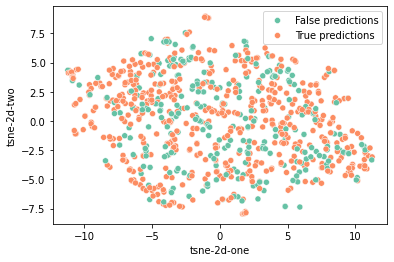

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 837 samples in 0.001s...
[t-SNE] Computed neighbors for 837 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 837 / 837
[t-SNE] Mean sigma: 1.924096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.876175
[t-SNE] KL divergence after 300 iterations: 1.487863


/mnt/d/Xiangyu/AWARE/utils/clustering.py:167: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(


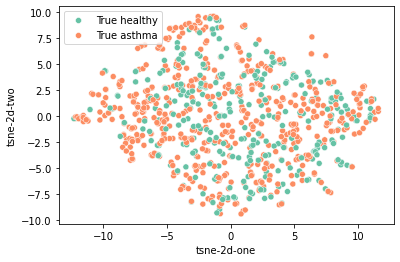

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 837 samples in 0.000s...
[t-SNE] Computed neighbors for 837 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 837 / 837
[t-SNE] Mean sigma: 1.924096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.874878
[t-SNE] KL divergence after 300 iterations: 1.485631


/mnt/d/Xiangyu/AWARE/utils/clustering.py:167: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(


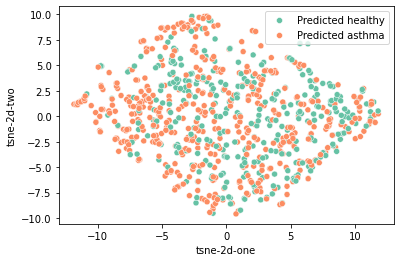

In [136]:
from utils.clustering import visualize
raw = np.zeros((0,84))
for split_idx, (train_loader, test_loader) in enumerate(splitter):
    inputs, masks, targets, info = next(iter(test_loader))
    raw = np.concatenate((raw, inputs), axis=0)

visualize(raw, y_pred==y_true, legend=['False predictions', 'True predictions'])

visualize(raw, y_true, legend=['True healthy', 'True asthma'])

visualize(raw, y_pred, legend=['Predicted healthy', 'Predicted asthma'])

<class 'str'>
